# Collaboration and Competition

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [20]:
!pip -q install ./python

The environment is already saved in the Workspace and can be accessed at the file path provided below. 

In [ ]:
from unityagents import UnityEnvironment
import numpy as np

env = UnityEnvironment(file_name="/data/Tennis_Linux_NoVis/Tennis")

Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [ ]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [ ]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Note that **in this coding environment, you will not be able to watch the agents while they are training**, and you should set `train_mode=True` to restart the environment.

In [ ]:
for i in range(5):                                         # play game for 5 episodes
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    while True:
        actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
        actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
    print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

When finished, you can close the environment.

In [ ]:
env.close()

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  A few **important notes**:
- When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```
- To structure your work, you're welcome to work directly in this Jupyter notebook, or you might like to start over with a new file!  You can see the list of files in the workspace by clicking on **_Jupyter_** in the top left corner of the notebook.
- In this coding environment, you will not be able to watch the agents while they are training.  However, **_after training the agents_**, you can download the saved model weights to watch the agents on your own machine! 

In [1]:
!pip -q install ./python

In [2]:
from ddpg_multi import Agent
from ddpg_multi import ReplayBuffer
import random
import torch
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
from unityagents import UnityEnvironment

%matplotlib inline
#%load_ext autoreload
%reload_ext autoreload

In [3]:
env = UnityEnvironment(file_name="/data/Tennis_Linux_NoVis/Tennis")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


In [5]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

random_seed = int(np.random.rand() * 100)

BUFFER_SIZE = int(1e6)  # replay buffer size
BATCH_SIZE = 256        # minibatch size

memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, random_seed)

agent = []
for i in range(num_agents):
    agent.append(Agent(state_size=state_size, action_size=action_size, random_seed=random_seed, memory=memory))

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.         -7.38993645 -1.5        -0.          0.
  6.83172083  5.99607611 -0.          0.        ]


In [6]:
def ddpg(n_episodes=5000, max_t=1000, num_agents=num_agents):
    scores_deque = deque(maxlen=100)
    scores_list = []
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]
        states = env_info.vector_observations
        scores = np.zeros(num_agents)
        while True:
            actions = []
            for i_agent in range(num_agents):
                agent[i_agent].reset()
                actions.append(agent[i_agent].act(states[i_agent]))
            env_info = env.step(actions)[brain_name]           # send all actions to the environment
            next_states = env_info.vector_observations         # get next state for each agent
            rewards = env_info.rewards                         # get reward for each agent
            dones = env_info.local_done                        # check done
            
            for i_agent in range(num_agents):
                agent[i_agent].step(states[i_agent], actions[i_agent], rewards[i_agent], next_states[i_agent],dones[i_agent])
            
            for i_agent in range(num_agents):
                agent[i_agent].update_t_step()
            
            for i_agent in range(num_agents):
                agent[i_agent].step_learn()
                
            states = next_states
            scores += rewards
            if np.any(dones):
                break 
                
        scores_deque.append(np.amax(scores))
        scores_list.append(np.amax(scores))
        
        print('\rEpisode {}\tAverage Score Last 100 Episodes: {:.5f}\tMax Score (All Agents) Last Episode: {:.2f}'.format(i_episode, np.mean(scores_deque), np.amax(scores)), end="")
        
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score Last 100 Episodes: {:.5f}'.format(i_episode, np.mean(scores_deque)))
            for i in range(num_agents):
                torch.save(agent[i].actor_local.state_dict(), 'tennis-ddpg-actor-agent%d.pth' %i)
                torch.save(agent[i].critic_local.state_dict(), 'tennis-dppg-critic-agent%d.pth' %i)

        if np.mean(scores_deque) >= 0.5:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.5f}'.format(i_episode-100, np.mean(scores_deque)))
            for i in range(num_agents):
                torch.save(agent[i].actor_local.state_dict(), 'tennis-solved-ddpg-actor-solved-agent%d.pth' %i )
                torch.save(agent[i].critic_local.state_dict(), 'tennis-solved-ddpg-critic-solved-agent%d.pth' %i)
            break

        if i_episode == n_episodes: 
            print('\nMax episodes reached!\tFinal Average Score: {:.5f}'.format(i_episode, np.mean(scores_deque)))
            for i in range(num_agents):
                torch.save(agent[i].actor_local.state_dict(), 'tennis-max-ddpg-actor-agent%d.pth' %i)
                torch.save(agent[i].critic_local.state_dict(), 'tennis-max-ddpg-critic-agent%d.pth' %i)
    
    return scores_list

scores = ddpg()

Episode 100	Average Score Last 100 Episodes: 0.00690	Max Score (All Agents) Last Episode: 0.00
Episode 200	Average Score Last 100 Episodes: 0.04170	Max Score (All Agents) Last Episode: 0.00
Episode 300	Average Score Last 100 Episodes: 0.06180	Max Score (All Agents) Last Episode: 0.00
Episode 400	Average Score Last 100 Episodes: 0.05610	Max Score (All Agents) Last Episode: 0.10
Episode 500	Average Score Last 100 Episodes: 0.06810	Max Score (All Agents) Last Episode: 0.10
Episode 600	Average Score Last 100 Episodes: 0.05830	Max Score (All Agents) Last Episode: 0.10
Episode 700	Average Score Last 100 Episodes: 0.05690	Max Score (All Agents) Last Episode: 0.00
Episode 800	Average Score Last 100 Episodes: 0.04890	Max Score (All Agents) Last Episode: 0.10
Episode 900	Average Score Last 100 Episodes: 0.04890	Max Score (All Agents) Last Episode: 0.10
Episode 1000	Average Score Last 100 Episodes: 0.05590	Max Score (All Agents) Last Episode: 0.10
Episode 1100	Average Score Last 100 Episodes: 0.0

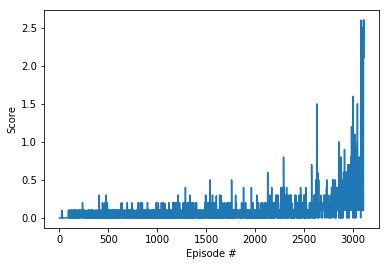

In [7]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

In [8]:
env.close()